# Cities in Motion: Student Hackathon

This notebook covers initial data exploration of the Urban Scanner dataset.

In [1]:
import os
os.chdir("..")

from pandas import DataFrame
import pandas as pd
import numpy as np

from data import *

fishnet_predictors, gis_samples = read_gis_predictors()
fishnets = read_fishnet(verbose=True)
wind_speeds = read_r3()

drove_on = read_drove_on()

In [2]:
gis_samples

,Unnamed: 0,id,FID,centreline,Industrial_100m,Parks_100m,Water_100m,Governmental_100m,Residential_100m,Commercial_100m,...,npi_pm,distance_rail,distance_majorRD,distance_Highway,Id,NO2,visit,temp_yul,ws_yul,rh_yul
0,0,1,0,914019.0,7651.737852,0.0,0.0,0.0,11525.591230,0.0,...,1004.129385,1088.939233,7.762059,1.605203,914019.0,0.031648,5.0,6.800000,4.423868,58.952000
1,1,2,1,914019.0,13535.690660,0.0,0.0,0.0,0.000000,0.0,...,910.437838,1172.057984,103.386686,8.255360,914019.0,0.031648,5.0,6.800000,4.423868,58.952000
2,6,7,6,913964.0,1169.058466,0.0,0.0,0.0,2004.484808,0.0,...,755.502311,1041.805556,268.098235,4.568476,913964.0,0.032513,5.0,7.000000,4.012346,59.142000
3,15,16,15,14256124.0,1207.038772,0.0,0.0,0.0,4390.292436,0.0,...,792.123970,989.283759,259.672622,3.515294,14256124.0,0.039974,7.0,11.142857,4.041740,63.517143
4,16,17,16,30074508.0,1207.038772,0.0,0.0,0.0,4390.292436,0.0,...,792.123970,989.283759,259.672622,3.515294,30074508.0,0.038466,7.0,11.142857,4.041740,63.517143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6788,14461,14462,14461,2111674.0,10753.298680,0.0,0.0,0.0,16384.870950,0.0,...,1095.953697,455.521271,10.746660,3426.892908,2111674.0,0.018954,7.0,15.428571,3.527337,64.617143
6789,14462,14463,14462,103689.0,19511.478630,0.0,0.0,0.0,0.000000,0.0,...,1584.598474,1586.521889,1.814282,645.248242,103689.0,0.022251,6.0,14.166667,4.372428,71.168333
6790,14463,14464,14463,103689.0,15307.669600,0.0,0.0,0.0,0.000000,0.0,...,1549.361552,1582.779578,2.034489,745.242950,103689.0,0.022251,6.0,14.166667,4.372428,71.168333
6791,14464,14465,14464,103689.0,15480.124670,0.0,0.0,0.0,0.000000,0.0,...,1520.405464,1579.561418,1.425359,845.226749,103689.0,0.022251,6.0,14.166667,4.372428,71.168333


In [3]:
wind_speeds

,Join_Count,TARGET_FID,JOIN_FID,Timestamp,Lat1,Long1,WS,WD,VS,VD,Temp,RH,NO2,ORIG_FID,Lat,Long,RoadNetwor,Id
0,0,4710,-1,2021-06-01 12:30,0.000000,0.000000,3.848651,195.213229,2.508872,63.484769,25.066434,34.170986,0.021344,0,43.771995,-79.281228,0,0
1,1,74,0,2021-06-01 11:09,43.663060,-79.393153,1.382353,320.647059,17.363059,84.652941,15.538000,34.886000,0.007479,21209,43.663096,-79.392934,1143323,21209
2,1,83,1,2021-06-01 11:09,43.663152,-79.392830,1.377778,320.333333,10.220729,84.711111,15.538000,34.886000,0.009312,21211,43.663123,-79.392734,30030386,21211
3,1,88,2,2021-06-01 11:09,43.663259,-79.392780,1.280000,331.000000,14.365206,84.020000,15.538000,35.021800,0.012899,21212,43.663168,-79.392466,30030231,21212
4,1,87,3,2021-06-01 11:09,43.663226,-79.392856,1.400000,327.800000,11.585224,84.300000,15.538000,34.886000,0.011852,21240,43.663146,-79.392578,30030394,21240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57344,1,110,792,2021-07-30 14:30,43.659990,-79.394691,6.033333,192.410256,18.114423,165.326923,22.212923,46.818167,0.018181,64303,43.660091,-79.394561,7793201,64303
57345,1,8214,793,2021-07-30 16:55,43.672344,-79.375573,6.318519,169.555556,23.142843,287.833333,21.352185,50.365222,0.016929,64525,43.672439,-79.375516,1141663,64525
57346,1,8208,794,2021-07-30 16:55,43.672215,-79.374429,11.500000,67.181818,48.467905,292.136364,21.371364,51.097000,0.012928,64526,43.672287,-79.374436,1141699,64526
57347,1,8326,795,2021-07-30 16:57,43.673874,-79.375382,7.313333,29.866667,30.574159,151.393333,21.726000,49.954000,0.013692,64527,43.673879,-79.375137,14021616,64527


In [2]:
import numpy as np

def windspeed_decomp_prerocess(df: DataFrame, bias_deg:float = 0.00):

    # columns match `r3File_Merge1.csv`
    magnitude_col = "WS"
    direction_col = "WD"

    # copy df, filter, and convert timestamp
    df = df.copy()
    df = df[
        (df.Lat1 > 0.0) & # northen hemisphere
        (df.Long1 < 0.0) & # western hemisphere
        (df[direction_col] > 0.0) &
        (df.Temp > -35.00) &
        (df.RH > 0.0) &
        (df.RH < 100.0)
    ]
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df.dropna(subset=['Timestamp'], inplace=True)

    # decompose wind speed
    bias_rad = np.radians(bias_deg)
    df["direction_rad"] = np.radians(df[direction_col]) + bias_rad

    df["wind_x"] = df[magnitude_col] * np.sin(df["direction_rad"])
    df["wind_y"] = df[magnitude_col] * np.cos(df["direction_rad"])

    return df

test = windspeed_decomp_prerocess(wind_speeds)


In [7]:
test.Timestamp.max()

Timestamp('2021-08-03 13:28:00')

In [4]:
fishnets.keys()

dict_keys(['FishCenterJoin.shp', 'fishnet.shp', 'fishnetlable.shp'])

In [5]:

fishnets.get("fishnet.shp")

,Id,geometry
0,0,"POLYGON ((299168.683 4840563.776, 299268.683 4..."
1,1,"POLYGON ((314668.683 4836563.776, 314668.683 4..."
2,2,"POLYGON ((307068.683 4837363.776, 306968.683 4..."
3,3,"POLYGON ((297768.683 4834863.776, 297668.683 4..."
4,4,"POLYGON ((301568.683 4838363.776, 301468.683 4..."
...,...,...
65252,65252,"POLYGON ((303968.683 4827563.776, 304006.092 4..."
65253,65253,"POLYGON ((300768.683 4832063.776, 300668.683 4..."
65254,65254,"POLYGON ((317668.683 4833463.776, 317568.683 4..."
65255,65255,"POLYGON ((302068.683 4829263.776, 301968.683 4..."


In [ ]:
fishnets.get("FishCenterJoin.shp")

,Join_Count,TARGET_FID,Id,Id_1,geometry
0,1,0,0,23985,"POLYGON ((299168.683 4840563.776, 299268.683 4..."
1,1,1,1,13121,"POLYGON ((314668.683 4836563.776, 314668.683 4..."
2,1,2,2,15353,"POLYGON ((307068.683 4837363.776, 306968.683 4..."
3,1,3,3,9226,"POLYGON ((297768.683 4834863.776, 297668.683 4..."
4,1,4,4,17967,"POLYGON ((301568.683 4838363.776, 301468.683 4..."
...,...,...,...,...,...
65252,0,65252,65252,0,"POLYGON ((303968.683 4827563.776, 304006.092 4..."
65253,1,65253,65253,3454,"POLYGON ((300768.683 4832063.776, 300668.683 4..."
65254,1,65254,65254,6239,"POLYGON ((317668.683 4833463.776, 317568.683 4..."
65255,1,65255,65255,808,"POLYGON ((302068.683 4829263.776, 301968.683 4..."


<Axes: >

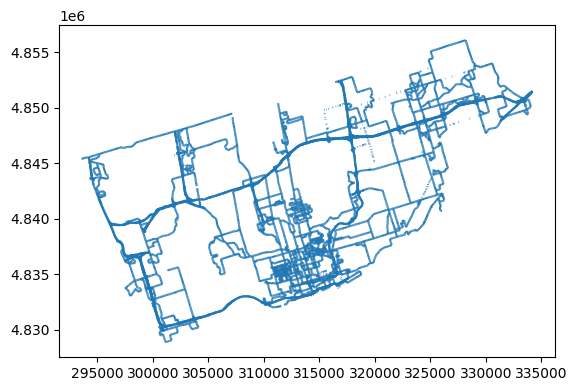

In [2]:
drove_on.plot()